<a href="https://colab.research.google.com/github/Migaalee/Deep_learning/blob/main/DeepNeuralNetworks_Migla_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - ADNE 2022 -Notebook1

## Deep neural networks using audio data 

### Aims

The main aim of this project is optimise several deep neural networks for audio files (4000 Hz heart sound files with 4 targets: S1, systolic, S2, dystolic. 

**FNN**

> A feedforward neural network (FNN) is one of the simplest neural networks where in connections between the nodes do not form a cycle. Each neuron in one layer has directed connections to the neurons of the subsequent layer and all multiple layers are interconnected in a feed-forward way.





**RNN**

> On the other hand, a recurrent neural network (RNN) is a class of neural networks where connections between nodes form a directed or undirected graph along a temporal sequence. RNNs can be used to process variable length sequences of inputs. 

**CNN** 

> A Convolutional neural network (CNN) are a specialized type of neural networks that use a mathematical operation called convolution in place of general matrix multiplication in at least one of their layers. Such networks are designed to process pixel data and are widely used in image recognition and processing.


**Transformers**

> A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data. Currently, it is often used in the field of natural language processing.


### How this works
This file is a [Jupyter Notebook](https://jupyter.org). 
It has instructions, and also code cells. The code cells are connected to Python, and you can run all of the code in a cell by pressing Play (▶) icon in the top bar, or pressing `shift + return`.
The code libraries you should need are already installed.


## Data pre-processing

### Import all required libraries

In [12]:
import glob
import numpy as np
import tensorflow as tf
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt


#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error
sns.set()
from tensorflow import keras
from datetime import datetime
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from keras.constraints import maxnorm
from tensorflow.keras.layers import GlobalAveragePooling1D, Input, BatchNormalization, MaxPooling2D, Flatten, Conv2D, Dense, Activation, Dropout, concatenate, Reshape, UpSampling1D, Conv1D, MaxPooling1D
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed,Input, Reshape, UpSampling1D, Conv1D
from keras.layers.recurrent import LSTM
import os
from keras.layers import Embedding
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
from keras.layers import LeakyReLU, Embedding
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Mounted at /content/drive


### Auxilary functions

In [14]:
def read_npy(fname):
    """fname should be a npy file; função auxiliar que vai ser usada pela função 'map' para ler o conteúdo de cada um dos ficheiros do fnames_dataset e criar um novo dataset com estes conteúdos."""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

def cut_data(x):
  N = tf.shape(x)[1]
  r = tf.random.uniform(shape=[], maxval = (N - L), dtype = tf.dtypes.int32)
  return x[:, N - r - L: N - r]

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)




Testing GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

### Import data for training, validation and testing

In [15]:
os.chdir("/content/drive/MyDrive/adneDataAlunos/")
dir = './'
list_train_files = glob.glob(dir + "trainAlunos/" + '*.npy')
list_valid_files = glob.glob(dir + "validacaoAlunos/" + '*.npy')
list_test_files = glob.glob(dir + "testeAlunos/" + '*.npy')
data_train = tf.data.Dataset.from_tensor_slices(list_train_files) #creates a dataset with a separate element for each row of the input tensor, this will be important to put our different examples in separate tensors
data_valid = tf.data.Dataset.from_tensor_slices(list_valid_files)
data_test = tf.data.Dataset.from_tensor_slices(list_test_files)
data_train = data_train.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_valid = data_valid.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_test = data_test.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))



### Visualisation of one tensor

In [16]:
it = iter(data_train) #creates an object which can be iterated one element at a time
ex = next(it) # returns the next item in an iterator
ex
#valid: shape=(2, 24002), train: shape=(2, 48000), test: shape=(2, 41325)

(<tf.Tensor: shape=(2, 48000), dtype=float32, numpy=
 array([[ 199.,   47., -166., ...,   47.,   86.,  -66.],
        [   4.,    4.,    4., ...,    4.,    4.,    4.]], dtype=float32)>,)

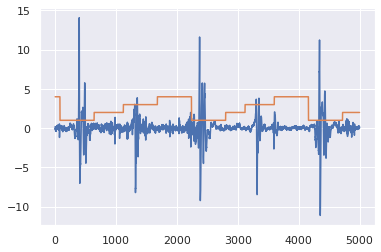

In [17]:
ex[0].shape
aux=ex[0]
plt.plot(aux[0,:5000]/1000)
plt.plot(aux[1,:5000])

### Segment data into pieces

In [18]:
L=2000
data_train_cut = data_train.map(cut_data)
data_test_cut = data_test.map(cut_data)
data_valid_cut = data_valid.map(cut_data)

### STFT transformation

#### This STFT transformed data (cut into 2000) will be used for FFN

In [111]:
frame_length=256
frame_step =32
frame_length1=128
frame_step1 =32
frame_length2=64
frame_step2 =32
frame_length3=16
frame_step3 =8
frame_length4=512
frame_step4 =256

data_train_stft = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_test_stft = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_valid_stft = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_train_stft1 = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1)), x[1]))
data_test_stft1 = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1)), x[1]))
data_valid_stft1 = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1)), x[1]))
data_train_stft2 = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_test_stft2 = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_valid_stft2 = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_train_stft3 = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length3, frame_step = frame_step3)), x[1]))
data_test_stft3 = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length3, frame_step = frame_step3)), x[1]))
data_valid_stft3 = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length3, frame_step = frame_step3)), x[1]))

data_train_stft4= data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length4, frame_step = frame_step4)), x[1]))
data_test_stft4 = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length4, frame_step = frame_step4)), x[1]))
data_valid_stft4 = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length4, frame_step = frame_step4)), x[1]))

####  This STFT transformed data will be used for RNN, CNN, Transformers

In [120]:
data_size_var_train = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))
data_size_var_test = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))
data_size_var_valid = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))

data_size_var_train1 = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1))), x[1]))
data_size_var_test1 = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1))), x[1]))
data_size_var_valid1 = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1))), x[1]))

data_size_var_train2 = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2))), x[1]))
data_size_var_test2 = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2))), x[1]))
data_size_var_valid2 = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2))), x[1]))


data_size_var_train3 = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length3, frame_step = frame_step3))), x[1]))
data_size_var_test3 = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length3, frame_step = frame_step3))), x[1]))
data_size_var_valid3 = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length3, frame_step = frame_step3))), x[1]))


data_size_var_train4 = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length4, frame_step = frame_step4))), x[1]))
data_size_var_test4 = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length4, frame_step = frame_step4))), x[1]))
data_size_var_valid4 = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length4, frame_step = frame_step4))), x[1]))

### Define batch size for segmented data

In [113]:
batch_size=2
input_train = data_train_stft.batch(batch_size)
input_test = data_test_stft.batch(batch_size)
input_valid = data_valid_stft.batch(batch_size)

input_train1 = data_train_stft1.batch(batch_size)
input_test1 = data_test_stft1.batch(batch_size)
input_valid1 = data_valid_stft1.batch(batch_size)

input_train2= data_train_stft2.batch(batch_size)
input_test2 = data_test_stft2.batch(batch_size)
input_valid2 = data_valid_stft2.batch(batch_size)




# Define batch size and add padding for variable size data

In [121]:
batch_size = 2
k = 129 #shape of x of input_variable_train
k1 = 65
k2 = 33
k3 = 9
k4=257

input_variable_train = data_size_var_train.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
input_variable_test = data_size_var_test.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
input_variable_valid = data_size_var_valid.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))

input_variable_train1 = data_size_var_train1.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k1])), [None]))
input_variable_test1 = data_size_var_test1.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k1])), [None]))
input_variable_valid1 = data_size_var_valid1.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k1])), [None]))

input_variable_train2 = data_size_var_train2.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k2])), [None]))
input_variable_test2 = data_size_var_test2.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k2])), [None]))
input_variable_valid2 = data_size_var_valid2.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k2])), [None]))


input_variable_train3 = data_size_var_train3.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k3])), [None]))
input_variable_test3 = data_size_var_test3.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k3])), [None]))
input_variable_valid3 = data_size_var_valid3.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k3])), [None]))

input_variable_train4 = data_size_var_train4.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k4])), [None]))
input_variable_test4 = data_size_var_test4.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k4])), [None]))
input_variable_valid4 = data_size_var_valid4.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k4])), [None]))



### Check input shape for cut data

In [122]:
it1 = iter(input_variable_valid4)
ex1 = next(it1)
ex1 #input_train: shape=(2, 55, 129) data_size_var_train shape=(1493, 129), input_variable_train shape=(2, 1493, 129)
# data_size_var_train shape=(1493, 129) data_size_var_train1 shape=(1497, 65) data_size_var_train2 shape=(1499, 33) # data_size_var_train3 shape=(5999, 9), data_size_var_train4 shape=(374, 129)

((<tf.Tensor: shape=(2,), dtype=int32, numpy=array([24002, 19760], dtype=int32)>,
  <tf.Tensor: shape=(2, 92, 257), dtype=float32, numpy=
  array([[[3.5069106e+03, 4.0793867e+03, 9.3082041e+03, ...,
           4.0492157e+01, 2.0264843e+01, 2.4007935e+01],
          [7.5620532e+03, 1.3644040e+04, 1.7828512e+04, ...,
           5.8783367e+01, 3.7405289e+01, 5.7314453e+00],
          [1.8803621e+04, 2.1757680e+04, 1.8341588e+04, ...,
           6.0304623e+01, 5.4558037e+01, 4.1676758e+01],
          ...,
          [1.3640516e+03, 1.5890222e+04, 2.6753848e+04, ...,
           6.0183071e+01, 7.7799835e+01, 9.2375732e+01],
          [4.7822598e+03, 1.3282103e+04, 1.8838701e+04, ...,
           5.0399021e+01, 6.1371971e+01, 5.9082275e+01],
          [7.2808555e+03, 1.3749364e+04, 3.8899512e+04, ...,
           1.3053679e+01, 3.0674490e+01, 4.9296143e+01]],
  
         [[6.4943838e+03, 1.1741653e+04, 5.9216590e+04, ...,
           2.0608145e+01, 2.9320316e+01, 7.4231689e+01],
          [1.3050

### Define input shape for FNN

In [24]:
itera = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train),
                                           tf.compat.v1.data.get_output_shapes(input_train))
train_init_op = itera.make_initializer(input_train)

features, labels = itera.get_next()
sample = itera.get_next()
sample
input_shape = np.shape((sample)[0])[1:]
print(input_shape)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
(55, 129)


In [25]:
itera1 = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train1),
                                           tf.compat.v1.data.get_output_shapes(input_train1))
train_init_op1 = itera1.make_initializer(input_train1)

features, labels = itera1.get_next()
sample1 = itera1.get_next()
sample1
input_shape1 = np.shape((sample1)[0])[1:]
print(input_shape1)

(59, 65)


In [26]:
itera2 = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train2),
                                           tf.compat.v1.data.get_output_shapes(input_train2))
train_init_op2 = itera1.make_initializer(input_train2)

features, labels = itera2.get_next()
sample2 = itera2.get_next()
sample2
input_shape2 = np.shape((sample2)[0])[1:]
print(input_shape2)

(61, 33)


## FeedForward Neural network - all models in Notebook2

**Tested parameters: **

---

*   Batch size 2, 16 and 32
*   Optimisers: SGD, Adam, RMSprop
*   Learning rate: 0.1, 0.001, 0.0001
*   Passing different input sizes for STFT (Input: frame_length=256, frame_step =32, Input: frame_length=128, frame_step =32, Input: frame_length=64, frame_step =32)
*   Different number of layers with different sizes (Model1= 1024, 512, 256, 128, 100, Model2= 256, 128, 100, Model 3= Model2= 256, 100, Model 4= 128, 100)
*   Also, RelU and LeakyRelU was tried as activation functions. 
*   Batch normalisation was added and various dropout options.





## Recurrent Neural network

**Tested parameters: **

---

*   Batch size 2, 16 and 32
*   Optimisers: SGD, Adam.
*   Learning rate: 0.1, 0.5 and 0.001 (this one was running too slow, could not finish training)
*   Passing different input sizes for STFT (Input: frame_length=256, frame_step =32, Input: frame_length=128, frame_step =32, Input: frame_length=64, frame_step =32, Input: frame_length=32, frame_step =16)
*   Different number of layers with different sizes (Model1= LSTM(50), LSTM(50) with TimeDistributed(Dense(150)) did not seem to train anything with Input size 129 and learning rate of 0.5), Model2= LSTM(32), Dropout(0.5) with TimeDistributed(Dense(150)) and learning rate 0.1, 1h30 per epoch, trained only 5 epochs as google colab stopped several times)

In [140]:
NUM_EPOCHS = 5 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='loss', patience=2) 

### Models

In [64]:
def rnn_variable(opt, inputs, input_variable_valid, input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  #layer= LSTM(128,return_sequences=True)(inputs) 
  #layer = Activation("relu")(layer)
  #layer= LSTM(32,return_sequences=True)(inputs)
  #layer = BatchNormalization(axis=-1)(layer)
  #layer = Activation("LeakyReLU")(layer)
  #layer= LSTM(64,return_sequences=True)(inputs)
  layer= LSTM(32,return_sequences=True)(inputs) 
  layer = Activation("LeakyReLU")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.5)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/5
1250/1250 [==============================] - 5168s 4s/step - loss: 1.6970 - sparse_categorical_accuracy: 0.2160 - val_loss: 1.6086 - val_sparse_categorical_accuracy: 0.1903
Epoch 2/5
1250/1250 [==============================] - 5193s 4s/step - loss: 1.6204 - sparse_categorical_accuracy: 0.2150 - val_loss: 1.6086 - val_sparse_categorical_accuracy: 0.2071
Epoch 3/5
1250/1250 [==============================] - 5180s 4s/step - loss: 1.6494 - sparse_categorical_accuracy: 0.2102 - val_loss: 1.6092 - val_sparse_categorical_accuracy: 0.1763
Epoch 4/5
1250/1250 [==============================] - 5230s 4s/step - loss: 1.6302 - sparse_categorical_accuracy: 0.2116 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1818
Epoch 5/5
1250/1250 [==============================] - 5186s 4s/step - loss: 1.6690 - sparse_categorical_accuracy: 0.2180 - val_loss: 1.7777 - val_sparse_categorical_accuracy: 0.1812
Model: "model_12"
___________________________________________________________________

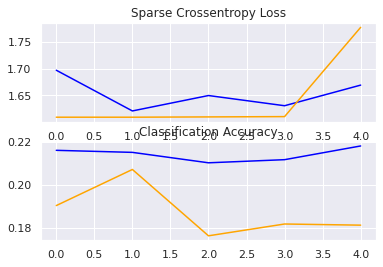

In [65]:
rnn= rnn_variable(opt2, input_variable_train2, input_variable_valid2,input_variable_test2)

In [87]:
def rnn_variable_c(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,257),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer= LSTM(50,return_sequences=True)(inputs) 
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer= LSTM(50,return_sequences=True)(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer= LSTM(50,return_sequences=True)(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1500))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train4, validation_data=input_variable_valid4, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test4, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

In [136]:
rnn1= rnn_variable_c(opt2, input_variable_train4, input_variable_valid4,input_variable_test4)

Epoch 1/10
   4/1250 [..............................] - ETA: 1:21:19 - loss: 7.2147 - sparse_categorical_accuracy: 0.2549

KeyboardInterrupt: ignored

In [154]:
def rnn_variable_b(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,257),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer= LSTM(200,return_sequences=True)(inputs) 
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer= LSTM(100,return_sequences=True)(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer= LSTM(50,return_sequences=True)(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train4, validation_data=input_variable_valid4, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test4, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

In [155]:

functional_rnn_var= rnn_variable_b(opt2, input_variable_train4, input_variable_valid4, input_variable_test4)

Epoch 1/5
  39/1250 [..............................] - ETA: 34:10 - loss: 8.0361 - sparse_categorical_accuracy: 0.2053

KeyboardInterrupt: ignored

In [152]:
def rnn_variable_a(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,257),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer= LSTM(100,return_sequences=True)(inputs) 
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer= LSTM(50,return_sequences=True)(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("relu")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train4, validation_data=input_variable_valid4, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test4, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/5
1250/1250 [==============================] - 1412s 1s/step - loss: 7.9088 - sparse_categorical_accuracy: 0.2030 - val_loss: 7.5936 - val_sparse_categorical_accuracy: 0.2102
Epoch 2/5
1250/1250 [==============================] - 1377s 1s/step - loss: 7.5414 - sparse_categorical_accuracy: 0.2095 - val_loss: 7.2189 - val_sparse_categorical_accuracy: 0.2215
Epoch 3/5
1250/1250 [==============================] - 1365s 1s/step - loss: 7.2194 - sparse_categorical_accuracy: 0.2176 - val_loss: 6.8050 - val_sparse_categorical_accuracy: 0.2288
Epoch 4/5
1250/1250 [==============================] - 1374s 1s/step - loss: 6.8889 - sparse_categorical_accuracy: 0.2253 - val_loss: 6.4872 - val_sparse_categorical_accuracy: 0.2380
Epoch 5/5
1250/1250 [==============================] - 1369s 1s/step - loss: 6.5271 - sparse_categorical_accuracy: 0.2309 - val_loss: 5.9910 - val_sparse_categorical_accuracy: 0.2459
Model: "model_48"
___________________________________________________________________

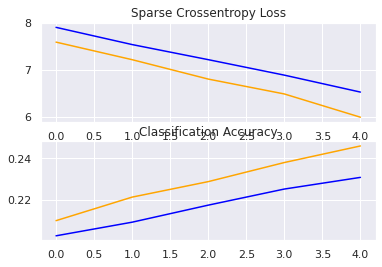

In [153]:
functional_rnn_var= rnn_variable_a(opt2, input_variable_train4, input_variable_valid4, input_variable_test4)

## Convolutional Neural network - all tested models in Notebook2

**Tested parameters: **

---

*   Batch size 16 and 32
*   Optimisers: SGD, Adam.
*   Learning rate: 0.1, 0.01 and 0.001 
*   Passing different input sizes for STFT (Input: frame_length=256, frame_step =32, Input: frame_length=128, frame_step =32, Input: frame_length=64, frame_step =32, Input: frame_length=32, frame_step =16)
*   Different number of layers with different sizes ((Model1= 1024, 512, 256, 128, 100, Model2= 256, 128, 100, Model 3= Model2= 256, 100, Model 4= 128, 100, Model 5: 256, 128, 256)
*   Also, RelU and LeakyRelU was tried as activation functions. 
*   Batch normalisation was added and various dropout options.

## Transformers - 3 of the models in Notebook2

In [158]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='sparse_categorical_accuracy', patience=2) 

In [159]:
def transformer_variable4(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 61s 47ms/step - loss: 3.0718 - sparse_categorical_accuracy: 0.2277 - val_loss: 2.0848 - val_sparse_categorical_accuracy: 0.2651
Epoch 2/100
1250/1250 [==============================] - 59s 47ms/step - loss: 2.1099 - sparse_categorical_accuracy: 0.2616 - val_loss: 2.0714 - val_sparse_categorical_accuracy: 0.2936
Epoch 3/100
1250/1250 [==============================] - 59s 47ms/step - loss: 2.0833 - sparse_categorical_accuracy: 0.2787 - val_loss: 1.9809 - val_sparse_categorical_accuracy: 0.2977
Epoch 4/100
1250/1250 [==============================] - 59s 47ms/step - loss: 1.9286 - sparse_categorical_accuracy: 0.2903 - val_loss: 1.7901 - val_sparse_categorical_accuracy: 0.2799
Epoch 5/100
1250/1250 [==============================] - 59s 47ms/step - loss: 1.7543 - sparse_categorical_accuracy: 0.3022 - val_loss: 1.7231 - val_sparse_categorical_accuracy: 0.3147
Epoch 6/100
1250/1250 [==============================] - 59s 47ms/step - lo

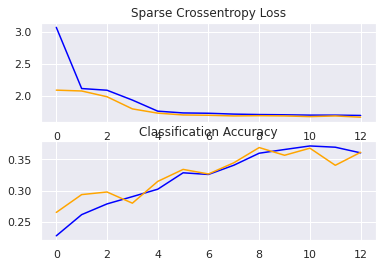

In [160]:
transformer4= transformer_variable4(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [161]:
def transformer_variable5(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf1)
  transf3 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf2)
  layer = layers.TimeDistributed(layers.Dense(150))(transf3)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 88s 68ms/step - loss: 2.5091 - sparse_categorical_accuracy: 0.2516 - val_loss: 2.2089 - val_sparse_categorical_accuracy: 0.2712
Epoch 2/100
1250/1250 [==============================] - 85s 68ms/step - loss: 1.9289 - sparse_categorical_accuracy: 0.2645 - val_loss: 1.6772 - val_sparse_categorical_accuracy: 0.2761
Epoch 3/100
1250/1250 [==============================] - 85s 68ms/step - loss: 1.6863 - sparse_categorical_accuracy: 0.2873 - val_loss: 1.6701 - val_sparse_categorical_accuracy: 0.3057
Epoch 4/100
1250/1250 [==============================] - 85s 68ms/step - loss: 1.6422 - sparse_categorical_accuracy: 0.3047 - val_loss: 1.5130 - val_sparse_categorical_accuracy: 0.3205
Epoch 5/100
1250/1250 [==============================] - 85s 68ms/step - loss: 1.5173 - sparse_categorical_accuracy: 0.3152 - val_loss: 1.4951 - val_sparse_categorical_accuracy: 0.3094
Epoch 6/100
1250/1250 [==============================] - 85s 68ms/step - lo

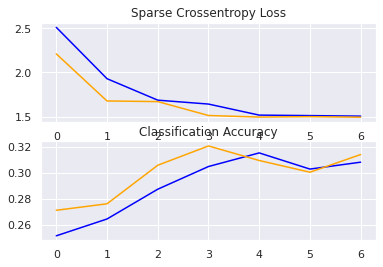

In [162]:
transformer5= transformer_variable5(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [163]:
def transformer_variable6(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=16, ff_dim=64)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 83s 65ms/step - loss: 2.3561 - sparse_categorical_accuracy: 0.2566 - val_loss: 1.7874 - val_sparse_categorical_accuracy: 0.2918
Epoch 2/100
1250/1250 [==============================] - 81s 65ms/step - loss: 1.7835 - sparse_categorical_accuracy: 0.2989 - val_loss: 1.7330 - val_sparse_categorical_accuracy: 0.3182
Epoch 3/100
1250/1250 [==============================] - 81s 65ms/step - loss: 1.7602 - sparse_categorical_accuracy: 0.3180 - val_loss: 1.7268 - val_sparse_categorical_accuracy: 0.3315
Epoch 4/100
1250/1250 [==============================] - 81s 65ms/step - loss: 1.6857 - sparse_categorical_accuracy: 0.3198 - val_loss: 1.6455 - val_sparse_categorical_accuracy: 0.3282
Epoch 5/100
1250/1250 [==============================] - 81s 65ms/step - loss: 1.6605 - sparse_categorical_accuracy: 0.3356 - val_loss: 1.6376 - val_sparse_categorical_accuracy: 0.3409
Epoch 6/100
1250/1250 [==============================] - 81s 65ms/step - lo

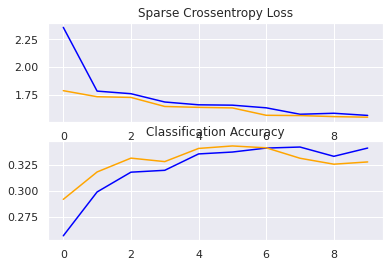

In [164]:
transformer6= transformer_variable6(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [165]:
def transformer_variable7(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 32 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf1)
  transf3 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf2)
  transf4 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf3)
  layer = layers.TimeDistributed(layers.Dense(150))(transf3)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 49s 37ms/step - loss: 2.5802 - sparse_categorical_accuracy: 0.2640 - val_loss: 2.0523 - val_sparse_categorical_accuracy: 0.2931
Epoch 2/100
1250/1250 [==============================] - 46s 36ms/step - loss: 2.0719 - sparse_categorical_accuracy: 0.2836 - val_loss: 2.0376 - val_sparse_categorical_accuracy: 0.2926
Epoch 3/100
1250/1250 [==============================] - 45s 36ms/step - loss: 1.9589 - sparse_categorical_accuracy: 0.3026 - val_loss: 1.8594 - val_sparse_categorical_accuracy: 0.3380
Epoch 4/100
1250/1250 [==============================] - 45s 36ms/step - loss: 1.8260 - sparse_categorical_accuracy: 0.3413 - val_loss: 1.7427 - val_sparse_categorical_accuracy: 0.3575
Epoch 5/100
1250/1250 [==============================] - 45s 36ms/step - loss: 1.7522 - sparse_categorical_accuracy: 0.3632 - val_loss: 1.7345 - val_sparse_categorical_accuracy: 0.3728
Epoch 6/100
1250/1250 [==============================] - 45s 36ms/step - lo

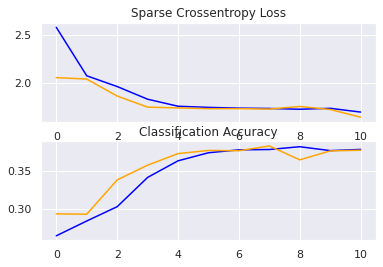

In [166]:
transformer7= transformer_variable7(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [177]:
def transformer_variable8(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf1 = Dropout(0.1)(transf1)
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf1)
  transf2 = Dropout(0.05)(transf2)
  transf3 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf2)
  transf3 = Dropout(0.05)(transf3)
  transf4 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf3)
  transf4 = Dropout(0.05)(transf4)
  layer = layers.TimeDistributed(layers.Dense(150))(transf4)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 70s 53ms/step - loss: 2.0215 - sparse_categorical_accuracy: 0.2414 - val_loss: 1.6153 - val_sparse_categorical_accuracy: 0.2774
Epoch 2/100
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5899 - sparse_categorical_accuracy: 0.2661 - val_loss: 1.4945 - val_sparse_categorical_accuracy: 0.2907
Epoch 3/100
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5216 - sparse_categorical_accuracy: 0.2768 - val_loss: 1.4951 - val_sparse_categorical_accuracy: 0.2986
Epoch 4/100
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5058 - sparse_categorical_accuracy: 0.2994 - val_loss: 1.4875 - val_sparse_categorical_accuracy: 0.3229
Epoch 5/100
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5107 - sparse_categorical_accuracy: 0.2959 - val_loss: 1.4765 - val_sparse_categorical_accuracy: 0.3249
Epoch 6/100
1250/1250 [==============================] - 65s 52ms/step - lo

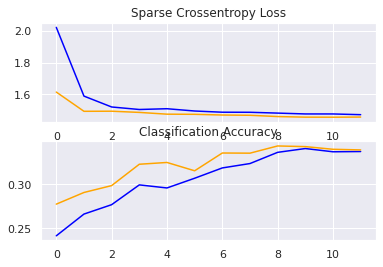

In [178]:
transformer8= transformer_variable8(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [179]:
def transformer_variable9(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf1 = Dropout(0.1)(transf1)
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf1)
  transf2 = Dropout(0.05)(transf2)
  transf3 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf2)
  transf3 = Dropout(0.05)(transf3)
  transf4 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf3)
  transf4 = Dropout(0.05)(transf4)
  layer = layers.TimeDistributed(layers.Dense(150))(transf4)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 116s 90ms/step - loss: 2.1226 - sparse_categorical_accuracy: 0.2214 - val_loss: 1.7688 - val_sparse_categorical_accuracy: 0.2526
Epoch 2/100
1250/1250 [==============================] - 112s 89ms/step - loss: 1.7777 - sparse_categorical_accuracy: 0.2365 - val_loss: 1.7681 - val_sparse_categorical_accuracy: 0.2600
Epoch 3/100
1250/1250 [==============================] - 112s 90ms/step - loss: 1.7715 - sparse_categorical_accuracy: 0.2433 - val_loss: 1.7633 - val_sparse_categorical_accuracy: 0.2657
Epoch 4/100
1250/1250 [==============================] - 112s 89ms/step - loss: 1.7425 - sparse_categorical_accuracy: 0.2510 - val_loss: 1.6772 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/100
1250/1250 [==============================] - 112s 89ms/step - loss: 1.6382 - sparse_categorical_accuracy: 0.2601 - val_loss: 1.5081 - val_sparse_categorical_accuracy: 0.2822
Epoch 6/100
1250/1250 [==============================] - 112s 89ms/ste

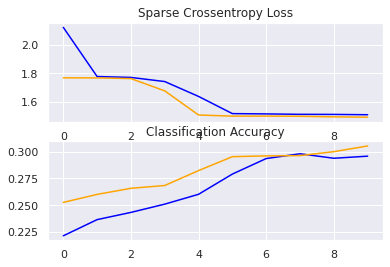

In [180]:
transformer9= transformer_variable9(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [181]:
def transformer_variable10(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 32 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf1)
  transf3 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf2)
  transf4 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf3)
  transf5 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf4)
  transf6 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf5)
  transf7 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf6)
  transf8 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf7)
  layer = layers.TimeDistributed(layers.Dense(150))(transf8)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 116s 87ms/step - loss: 3.3322 - sparse_categorical_accuracy: 0.2293 - val_loss: 2.9847 - val_sparse_categorical_accuracy: 0.2522
Epoch 2/100
1250/1250 [==============================] - 108s 86ms/step - loss: 2.9759 - sparse_categorical_accuracy: 0.2395 - val_loss: 2.8910 - val_sparse_categorical_accuracy: 0.2507
Epoch 3/100
1250/1250 [==============================] - 108s 86ms/step - loss: 2.8090 - sparse_categorical_accuracy: 0.2450 - val_loss: 2.7290 - val_sparse_categorical_accuracy: 0.2631
Epoch 4/100
1250/1250 [==============================] - 108s 86ms/step - loss: 2.5741 - sparse_categorical_accuracy: 0.2764 - val_loss: 2.3161 - val_sparse_categorical_accuracy: 0.2971
Epoch 5/100
1250/1250 [==============================] - 108s 86ms/step - loss: 2.3402 - sparse_categorical_accuracy: 0.2922 - val_loss: 2.2920 - val_sparse_categorical_accuracy: 0.3125
Epoch 6/100
1250/1250 [==============================] - 108s 86ms/ste

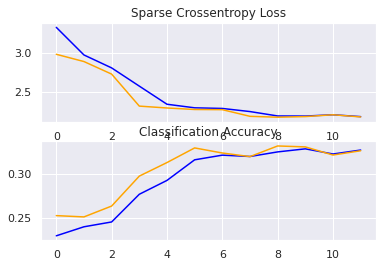

In [182]:
transformer10= transformer_variable10(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)